Heat equation on moving Domain
==============================
In this example we show how to solve a PDE on a changing domain. We consider a simple heat equation of the form
\begin{align*}
    \partial_t u - D\Delta u &= 0  \text{ in } \Omega \times [0, T] \\
    u(\cdot, 0) &= 0 \text{ in }\Omega \\
    u &= 0 \text{ on } \Gamma_\text{out}  \times [0, T] \\
    \vec{n} \nabla u &= q_\text{in} \text{ on } \Gamma_\text{in}(t)  \times [0, T]
\end{align*} 
Where $\Omega$ will be a circle, $ \Gamma_\text{out}$ the outer boundary of the circle and $\Gamma_\text{in}$ a inner boundary that will move in time. The moving boundary will be a hole, that rotates around the center of the circle $\Omega$.

In [1]:
import torchphysics as tp
import torch

First we define some parameters of the problem:

In [2]:
rot_speed = 2.0
rot_radius = 6.0
domain_radius = 12.0
hole_radius = 4.0
q_in = 10.0

In [3]:
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')

First the domain $\Omega$ will be created like always. For the moving hole, we can use a function that can depend on variables of the other spaces. Here the time variable ``t``.
This function can then be passed in as an input in the domain creation. Instead of setting an explicit value for the center, to a given point ``t`` the output of the function will be used.

Internally (e.g. all samplers) it is known, that first some time points have to be created to be able to sample points in the domain with the moving hole. 

One can also call the domain itself, to fix the domain at some desired point. Here for example: ``hole(t=1)`` will be a circle with radius=``hole_radius`` and center=``cos(rot_speed), sin(rot_speed)]``.

For now, we do **not** construct the cut of the domain and the hole, since for the boundary conditions it is more efficient to apply them part wise. See the explanations later on.

In [4]:
circle = tp.domains.Circle(X, [0, 0], domain_radius)

def center(t):
    # here we have to use column_stack to get a column vector, so the center is of the 
    # correct space dimension
    return rot_radius * torch.column_stack((torch.cos(rot_speed * t), torch.sin(rot_speed * t)))

hole = tp.domains.Circle(X, center, hole_radius)
t_int = tp.domains.Interval(T, 0, 2)

The model like always:

In [5]:
model = tp.models.Sequential(
    tp.models.NormalizationLayer(circle*t_int),
    tp.models.FCN(input_space=X*T, output_space=U, hidden=(50,50,50,50,50,50))
)

Now we can start to define the conditions.

We start with the differential condition. This condition should at any time point be fulfilled inside the domain, 
therefore, we have to sample points in ``circle - hole``.
For this condition we use grid points, you could also change the sampler if you want. Everything else will be like always. Like mentioned before the ``Sampler`` will first create the points of the time interval and then pass them to the ``Sampler`` of the domain. So that to for any time point only domain points that lay not in the hole are used. 

In [6]:
circle_with_hole = circle - hole
inner_sampler = tp.samplers.GridSampler(circle_with_hole, n_points=2000) *  tp.samplers.GridSampler(t_int, n_points=50)
inner_sampler = inner_sampler.make_static()

def pde_residual(u, x, t):
    return 3.0 * tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=pde_residual,
                                            name='pde_condition')

The Dirichlet-Condition should only be applied at the outer boundary. Therefore, it is smarter to just use the boundary of ``circle`` and not of ``circle - hole``. If we used ``circle - hole``, points at the inner boundary would be created too, and we have to use a filter to get the correct ones.

In [7]:
dirichlet_sampler = tp.samplers.RandomUniformSampler(circle.boundary*t_int, n_points=3000)

def dirichlet_residual(u):
    return u

dirichlet_condition = tp.conditions.PINNCondition(module=model,
                                                  sampler=dirichlet_sampler,
                                                  residual_fn=dirichlet_residual,
                                                  name='dirichlet_condition')

The same applies to the source condition at the hole boundary:

In [8]:
source_sampler = tp.samplers.RandomUniformSampler(hole.boundary*t_int, n_points=15000)

def source_residual(u, t, x):
    normals = hole.boundary.normal(x, tp.spaces.Points(t, T))
    heat_source = q_in * (1 - torch.exp(-t))
    # here we multiply by some term to get a continuous heat source in time
    normal_deriv = tp.utils.normal_derivative(u, normals, x)
    return normal_deriv + heat_source

source_condition = tp.conditions.PINNCondition(module=model,
                                               sampler=source_sampler,
                                               residual_fn=source_residual,
                                               name='source_condition')

In [9]:
initial_sampler = tp.samplers.RandomUniformSampler(circle_with_hole*t_int.boundary_left, n_points=5000).make_static()

def initial_residual(u):
    return u

initial_condition = tp.conditions.PINNCondition(module=model, 
                                                sampler=initial_sampler, 
                                                residual_fn=initial_residual)

This is everthing you have to pay attention to, if a moving domain is used. Now we can start the training like always: 

In [10]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([source_condition, pde_condition, initial_condition, dirichlet_condition],
                          optimizer_setting=optim)

import pytorch_lightning as pl
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

trainer = pl.Trainer(gpus=1, # or None for CPU
                     max_steps=5000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 13.0 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domainoperations/sampler_helper.py:49: UserWarning: Will sample random points in the created domain operation, with
                     a for loop over all input parameters, in total: 1
                     This may slow down the training.
  warnings.warn(f"""Will sample random points in the created domain operation, with
/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domainoperations/cut.py:41: UserWarning: Exact volume of this cut is not known, will use the
                             estimate: volume = domain_a.volume.
                             If you need the exact volume for sampling,
                             use domain.set_volume()
  warnings.warn("""Exact volume of this cut is not known, will use the


Validating: 0it [00:00, ?it/s]

In [14]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.05, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})

# make sampler static:
pde_condition.sampler = pde_condition.sampler.make_static()
dirichlet_condition.sampler = dirichlet_condition.sampler.make_static()
source_condition.sampler = source_condition.sampler.make_static()
initial_condition.sampler = initial_condition.sampler.make_static()

solver = tp.solver.Solver([source_condition, pde_condition, initial_condition, dirichlet_condition],
                          optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=3000, 
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 13.0 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Lastly we can plot the solution or even create an animation.
The gif can be found under moving-heat-eq.gif.

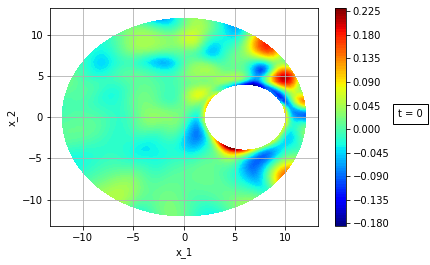

In [12]:
plot_sampler = tp.samplers.PlotSampler(circle_with_hole, n_points=2500, data_for_other_variables={'t':0})

fig = tp.utils.plot(model, lambda u: u, plot_sampler, plot_type='contour_surface')

MovieWriter ffmpeg unavailable; using Pillow instead.


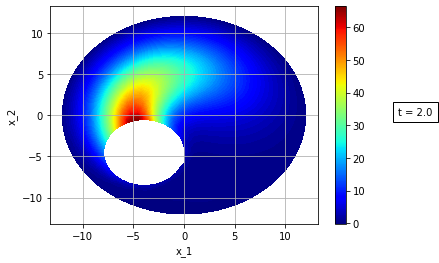

In [13]:
#anim_sampler = tp.samplers.AnimationSampler(circle_with_hole, t_int, 100, n_points=900)
#fig, anim = tp.utils.animate(model, lambda u: u[:, 0], anim_sampler, ani_speed=10, ani_type='contour_surface')
#anim.save('moving-heat-eq.gif')